# Sequential Monte Carlo (SMC)
When we have data coming in a form of sequence, we try to evaluate the next T steps of the data. This help us see the future to some extend which maybe used to avoid some catastrophe. This has huge applications in the current industry. Like auto-scaling of queues based on predition on past days data.

Now there are 2 types of models in Sequential structure. In one kind we worry about each of the intermediate marginal distribution and the other we care about only the final distribution. The 1st kind is called particle filtering. We are going to talk about particle filtering here. 2nd kind is called SMC sampler

## State space model

State space models are sequencial model whose value of current sequence depends on some latent variable sequence. This can se said as graphical models with chain structure. These have a form as below,
$$
p(y_{1:T},z_{1:T}|u_{1:T}) = [p(z_1|u_1)\prod_{t=2}^T p(z_t|z_{t-1},u_t)]\:[\prod_{t=1}^{T} p(y_t|z_t, u_t)] 
$$
Here, Inital state  is $p(z_1|u_1)$, $\prod_{t=2}^T p(z_t|z_{t-1},u_t)$ is the dynamic/transistion model, $\prod_{t=1}^{T} p(y_t|z_t, u_t)$ is the observation/measurement model.

For more details check reference books on it, However I am going to write a sample using a most commonly used example function of SSMs, a 2d non-linear tracking problem with 
$$
p(z_t|z_{t-1}) = N(z_1|f(z_{t-1}),qI) \\
p(y_t|z_t) = N(y_t|z_t, rI) \\
f(z) = (z_1 + \Delta sin(z_2), z_2+\Delta cos(z_1))
$$




<Axes: title={'center': 'custom linear gaussian state space model'}>

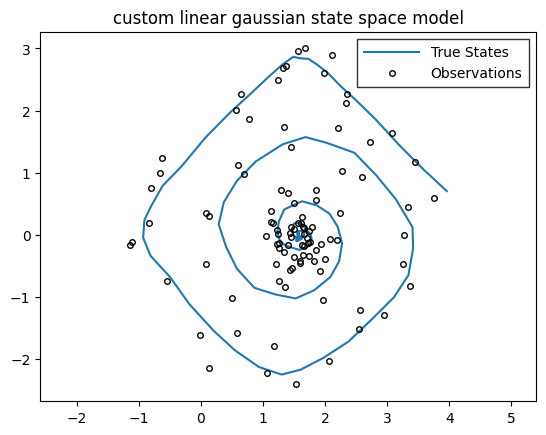

In [2]:
from typing import Callable
import torch
import matplotlib.pyplot as plt

class CustomSSM:

    def __init__(self, z_function: Callable, q=0.001, r=0.05):
        self.z_function = z_function
        self.q = q
        self.r = r

    def z_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=z_function(zt),
                                                      covariance_matrix=self.q * torch.eye(zt.shape[-1]))
    
    def y_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=zt,
                                                      covariance_matrix=self.r * torch.eye(zt.shape[-1]))

    def sample_y(self, zt_next):
        p_y = self.y_dist(zt_next)
        yt_next = p_y.sample()
        return yt_next

    def sample_z(self, zt):
        p_z = self.z_dist(zt)
        zt_next = p_z.sample()
        return zt_next
    
    def _step(self, zt = torch.tensor([1.5, 0.0])):
        zt_next = self.sample_z(zt)
        yt_next = self.sample_y(zt_next)
        return zt_next, torch.stack((zt_next, yt_next))
    
    def samples(self, z0, N_s = 100):
        def scan(func, init_values, length):
            carry = init_values
            logs_chain = []
            for i in range(length):
                carry, logs = func(carry)
                logs_chain.append(logs)
            logs_output = torch.stack(logs_chain,dim=1)
            return carry, logs_output
       
        _, logs_chain = scan(self._step, z0, N_s)
        # (zt,yt)
        return logs_chain
    
def z_function(z, delta=0.4):
    z_x = z[0] + delta * torch.sin(z[1])
    z_y = z[1] + delta * torch.cos(z[0])
    return torch.cat((torch.unsqueeze(z_x,0), torch.unsqueeze(z_y,0)))

model = CustomSSM(z_function)
z0 = torch.tensor([1.5, 0.0])

def plot_inference(samples, estimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
   
    states, emissions = samples[0], samples[1]
    if ax is None:
        fig, ax = plt.subplots()
    if show_states:
        ax.plot(*states.T, label="True States")
    ax.plot(*emissions.T, "ok", fillstyle="none", ms=4, label="Observations")
    if estimates is not None:
        ax.plot(*estimates.T, color="r", linewidth=1.5, label=f"{est_type} Estimate")
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.axis('equal')
    return ax
samples = model.samples(z0, 100)
plot_inference(samples, title='custom linear gaussian state space model')

# Sequential importance sampling

This is one of the techniques to generate samples and give preferences to weights by normalizing it in particle filtering. Here we consider the proposal distribution to have a from of,
$$
q_t(z_{1:t}) = q_{t-1}(z_{1:t-1})q_t(z_t|z_{1:t-1})
$$






For this example we take a gaussian model with latent defined by
$$
p(z_t|z_{1:t-1}) = N(z_t|\phi z_{t-1},q)
$$
and the output sequence dependent on latent is given by
$$
p(y_t|z_{1:t}) = N(y_t|\sum_{s=1}^t \beta^{t-s}z_s,r)
$$
So for coding purpose if we break the above equation and use the pre-calculated $\mu$ then the break-down for $t=5$ becomes,
$$
\mu_{current} = \beta^4z_1 + \beta^3z_2 + \beta^2z_3 + \beta z_4 + z_5 \\
\mu_{next} = \beta^5z_1 + \beta^4z_2 + \beta^3z_3 + \beta^2 z_4 + \beta z_5 + z_6 \\
\mu_{next} = \beta(\beta^4z_1 + \beta^3z_2 + \beta^2z_3 + \beta z_4 + z_5) + z_6 \\
\mu_{next} = \beta(\mu_{current}) + z_6 \\
$$ 
So, our equation becomes,
$$
\mu_{t} = \beta(\mu_{t-1}) + z_t \\
$$

In [81]:
import torch
from typing import List, NamedTuple

import torch.distributed

class Constants(NamedTuple):
    phi: torch.Tensor = torch.tensor([0.9])
    q: torch.Tensor = torch.tensor([10.0])
    beta: torch.Tensor = torch.tensor([0.5])
    r: torch.Tensor = torch.tensor([1.0])

init_constants = Constants()

class GaussianSequenceModel:

    def __init__(self, init_constants: Constants):
        self.init_constants = init_constants
    
    def sample_z_step(self, prev_zt):
        phi = self.init_constants.phi
        q = self.init_constants.q
        zt = torch.distributions.Normal(loc=phi*prev_zt, scale=torch.sqrt(q)).sample()
        return zt

    def y_step(self, prev_y_mu_t, zt):
        beta = self.init_constants.beta
        r = self.init_constants.r
        mu_t = torch.vmap(lambda mu_i,z_i_t : beta*mu_i+z_i_t)(prev_y_mu_t,zt)
        y_t_dist = torch.distributions.Normal(loc=mu_t, scale=torch.sqrt(r))
        return mu_t, y_t_dist

    def sample_y_step(self, prev_y_mu_t, zt):
        mu_t, y_t_dist = self.y_step(prev_y_mu_t, zt)
        y_t = y_t_dist.sample()
        return mu_t.ravel(), y_t.ravel()
    
    def sample_step(self, prev_zt, prev_y_mu_t):
        zt = self.sample_z_step(prev_zt)
        mu_t, y_t = self.sample_y_step(prev_y_mu_t,zt)

        return (zt, mu_t), torch.cat((zt.unsqueeze(0), y_t.unsqueeze(0)))
    
    def sample(self, nsteps, N_s=1):
        mu_0, z_i_0 = self.inits(N_s)
        init_values = (mu_0,z_i_0)
        def scan(func, init_values, length):
            carry = init_values
            logs_chain = []
            for i in range(length):
                carry, logs = func(carry[0], carry[1])
                logs_chain.append(logs)
            logs_output = torch.stack(logs_chain,dim=1)
            return carry, logs_output
        _, logs_chain = scan(self.sample_step, init_values, nsteps)
        return logs_chain

    def inits(self, N_s):
        mu_0 = torch.zeros(N_s)
        z_i_0 = torch.zeros(N_s)
        return mu_0,z_i_0
    
    def sequential_importance_sampling(self, y_ts, T, N_s=10, sis=True):
        q = self.init_constants.q
        _, z_i_0 = self.inits(N_s)
        z_i_t = self.sample_z_step(z_i_0)
        w_i_1 = y_ts[0] / z_i_t
        W_i_1 = w_i_1 / w_i_1.sum()
        normalized_posterior_1 = (W_i_1*torch.abs(z_i_t.mean()-z_i_t)).sum()
        posteriors, normalized_w, latents = [], [], []
        latents.append(z_i_t)
        posteriors.append(normalized_posterior_1)
        normalized_w.append(W_i_1)
        for t in range(1,T):
            z_i_t = self.sis_sampling(z_i_t, latents[-1]) if sis else self.sisr_sampling(z_i_t, posteriors[-1])
            incremental_weight = y_ts[t] / (y_ts[t-1] * z_i_t)
            log_unnormalized_weight = w_i_1*incremental_weight
            log_normalized_weight = log_unnormalized_weight / log_unnormalized_weight.sum()
            normalized_w.append(log_normalized_weight)
            normalized_posterior_t = (log_normalized_weight*torch.abs(z_i_t.mean()-z_i_t)).sum()
            posteriors.append(normalized_posterior_t)
            latents.append(z_i_t)
        return posteriors, torch.stack(normalized_w)

    def sis_sampling(self, z_i_t, latent):
        z_i_t = self.sample_z_step(z_i_t) * latent
        return z_i_t

    def sisr_sampling(self, z_i_t, posterior):
        return self.sample_z_step(z_i_t) * posterior

particles = 5
T = 10
model = GaussianSequenceModel(init_constants)
samples = model.sample(T, N_s=particles)
print('sample (zts, yts) shape', samples.shape)
y_ts = torch.squeeze(samples.split(1)[-1])
print('only yts shape : ',y_ts.shape)
# SIS
posteriors_sis, weights_sis = model.sequential_importance_sampling(y_ts, T, N_s=5, sis=True)
# SISR
posteriors_smc, weights_smc = model.sequential_importance_sampling(y_ts, T, N_s=5, sis=False)
print(weights_sis)
print('---------------')
print(weights_smc)

sample (zts, yts) shape torch.Size([2, 10, 5])
only yts shape :  torch.Size([10, 5])
tensor([[-8.4232e-03,  3.3085e-02, -9.0591e-03,  9.8621e-01, -1.8134e-03],
        [ 4.2619e-02,  1.3648e-03,  5.8264e-03,  1.0273e+00, -7.7108e-02],
        [ 1.4866e-04, -2.7926e-05,  8.9049e-06,  9.9929e-01,  5.8501e-04],
        [-1.9639e-04,  3.3062e-07, -8.4339e-07,  1.0007e+00, -5.2551e-04],
        [ 2.4280e-04, -1.5068e-11,  2.0947e-10,  1.0017e+00, -1.9322e-03],
        [-1.8083e-06,  2.3636e-20, -2.8559e-17,  1.0184e+00, -1.8369e-02],
        [-1.2988e-09,  0.0000e+00, -4.1265e-32,  1.0841e+00, -8.4077e-02],
        [ 8.2696e-18, -0.0000e+00,  0.0000e+00,  9.0704e-01,  9.2956e-02],
        [-6.9233e-34,  0.0000e+00, -0.0000e+00, -6.6462e-02,  1.0665e+00],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00, -4.7562e-05,  1.0000e+00]])
---------------
tensor([[-2.4614e-03, -2.9030e-02, -2.9235e-03,  1.0342e+00,  1.7712e-04],
        [ 1.1899e-02,  6.2273e-03, -9.7815e-03,  9.9835e-01, -6.6939e-03]

In [84]:
import matplotlib.pyplot as plt

def plot_sis_weights(hist, n_steps, spacing=1.5, max_size=0.3):
    """
    Plot the evolution of weights in the sequential importance sampling (SIS) algorithm.

    Parameters
    ----------
    weights: array(n_particles, n_steps)
        Weights at each time step.
    n_steps: int
        Number of steps to plot.
    spacing: float
        Spacing between particles.
    max_size: float
        Maximum size of the particles.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)
    weights_subset = hist[:n_steps]
    for col, weights_row in enumerate(weights_subset):
        norm_cst = weights_row.sum()
        radii = weights_row / norm_cst * max_size
        for row, rad in enumerate(radii):
            if col != n_steps - 1:
                plt.arrow(spacing * (col + 0.25), row, 0.6, 0, width=0.05,
                          edgecolor="white", facecolor="tab:gray")
            circle = plt.Circle((spacing * col, row), rad, color="tab:red")
            ax.add_artist(circle)

    plt.xlim(-1, n_steps * spacing)
    plt.xlabel("Iteration (t)")
    plt.ylabel("Particle index (i)")

    xticks_pos = torch.arange(0, n_steps * spacing - 1, 2)
    xticks_lab = torch.arange(1, n_steps + 1)
    plt.xticks(xticks_pos, xticks_lab)

    return fig, ax

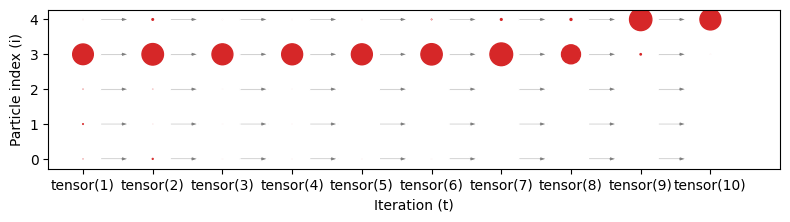

In [90]:
spacing = 2
fig, ax = plot_sis_weights(weights_sis, n_steps=10, spacing=spacing)
plt.tight_layout()

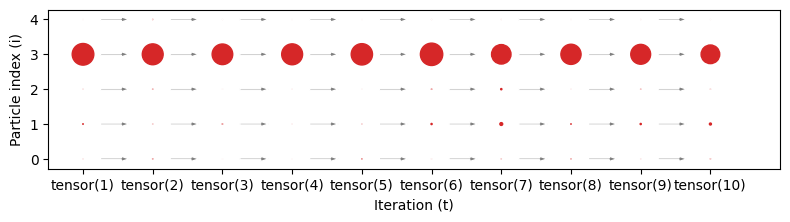

In [91]:
fig, ax = plot_sis_weights(weights_smc, n_steps=10, spacing=spacing)
plt.tight_layout()